# Deep Learning vs Traditional ML (Logistic Regression) Camprison Notebook

Now that we have trained LTSM with 2 million samples on Google Colab, we are going to compare the results with our traditional ML model (Logistic Regression)

We know that Logistic Regression's performance plateaus after about 200k samples and we know that LSTM is not performing as well as Logistic Regression with only 200k samples. 2 million is around the limit where we can use Google Colab to train our models while still working within the 24 hour backend limit. Further training for LSTM will probably have to be done on GCP using one of the GPU based compute instances.

We will take the results that we have so far to see if it's worth our while to keep training LSTM with more examples on GCP.


## Traditional ML Model

* Model: Logistic Regression
* Class weights: balanced
* Features: TF-IDF with 4k features
* Sample Size: 50k to 9mil

## Deep Learning Model

* Architecture: LSTM
* Class weights: balanced
* LSTM Nodes: 64
* Input Layer: Random Embedding (300)
* Sample Size: 50k to 2mill

    
# Conclusion

We good improvement (~ 0.6) in our score between 200k samples and 500k samples. However, improvement in our model between 500k samples to 1 million samples was minimal (0.017). We also saw a decrease in score (~ 0.03) between 500k and 1 million samples

Looking at the classification report more closely, we see that when score decreases with more samples, we generally see 2-star rating and 4-star rating recall decrease. We also see a slight decrease in accuracy in 1-star ratings. Generally, accuracy for 2-star and 4-star rating stays roughly the same (maybe with some slight improvements)





In [1]:
# import sibling utilities
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import importlib

import util.dict_util as du
import util.report_util as ru
import util.plot_util as pu

logging.basicConfig(level=logging.ERROR)

%matplotlib inline
sns.set(font_scale=2)


/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/vinceluk/anaconda3/envs/capstone/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/vinceluk/anaconda3/envs/

Load PySpark LR Report

In [2]:
# load report file form all of our deep learning models
REPORT_DIR = "../reports"
REPORT_LR = f'{REPORT_DIR}/201911-pyspark-report.csv'


report_lr = pd.read_csv(REPORT_LR, quotechar="'")
# flatten out classification report so we can graph later
report_lr = ru.convert_dnn_report_format(report_lr)

# calculate our custom score
report_lr["eval_metric"] = report_lr.classification_report.apply(lambda x: ru.calculate_metric(json.loads(x)))


ModelWrapper names the reports besed on run date so far. This has to be refactored. Some of the LSTM training was done in 11/2019 and others in 1/2020. Until then, we will merge 2 reports together into one


In [3]:
# runs from 11/2019
REPORT_LSTM_1 = f'{REPORT_DIR}/2019-11-dl_prototype-report.csv'
# runs from 1/2020
REPORT_LSTM_2 = f'{REPORT_DIR}/2020-01-dl_prototype-report.csv'

report_dnn = pd.read_csv(REPORT_LSTM_1, quotechar="'")
report_dnn = report_dnn.append(pd.read_csv(REPORT_LSTM_2, quotechar="'"), ignore_index=True, sort=False)



# report_lstm = report_dnn[(report_dnn.model_name == "LSTMB") & (report_dnn.sampling_type.isna())]
report_lstm64 = report_dnn[(report_dnn.model_name == "LSTMB") & (report_dnn.sampling_type == "none")].copy()
report_lstm64 = ru.convert_dnn_report_format(report_lstm64)

# calculate our custom score
report_lstm64["eval_metric"] = report_lstm64.classification_report.apply(lambda x: ru.calculate_metric(json.loads(x)))


Runs for LSTMB without dropout was done in 2/2020 so it's in a separate file

In [4]:
REPORT_LSTM_NODROP = f'{REPORT_DIR}/2020-02-dl_prototype-report.csv'

report202002 = pd.read_csv(REPORT_LSTM_NODROP, quotechar="'")
report202002 = ru.convert_dnn_report_format(report202002)
report202002["eval_metric"] = report202002.classification_report.apply(lambda x: ru.calculate_metric(json.loads(x)))



report_lstm64_nodrop = report202002[report202002.model_name.str.startswith("LSTMB_nodrop")]
report_lstm32 = report202002[report202002.model_name == "LSTMB32"]
report_lstm16 = report202002[report202002.model_name == "LSTMB16"]

In [5]:
report_lr[["train_examples", "eval_metric"]]

,train_examples,eval_metric
0,44726.0,0.422127
1,89544.0,0.454550
2,179168.0,0.483252
3,447989.0,0.499181
4,896004.0,0.507036
5,1799736.0,0.514962
6,3599433.0,0.515266
7,8064337.0,0.517467


In [6]:
report_lstm64[["train_examples", "eval_metric"]].sort_values("train_examples")

,train_examples,eval_metric
0,149350.0,0.333960
2,448051.0,0.394009
3,896119.0,0.395784
1,1800000.0,0.367591


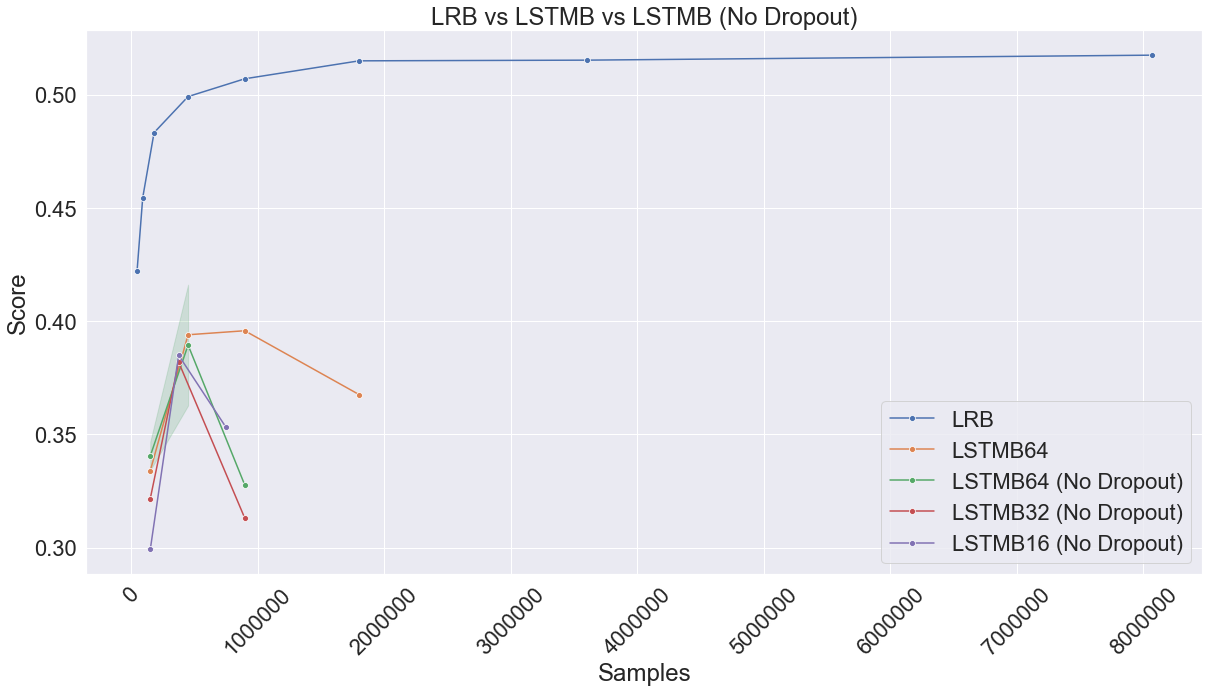

In [7]:
f, a = plt.subplots(1, 1, figsize=(20, 10))
sns.lineplot(data=report_lr, x="train_examples", y="eval_metric", marker="o", label="LRB")
sns.lineplot(data=report_lstm64, x="train_examples", y="eval_metric", marker="o", label="LSTMB64")
sns.lineplot(data=report_lstm64_nodrop, x="train_examples", y="eval_metric", marker="o", label="LSTMB64 (No Dropout)")
sns.lineplot(data=report_lstm32, x="train_examples", y="eval_metric", marker="o", label="LSTMB32 (No Dropout)")
sns.lineplot(data=report_lstm16, x="train_examples", y="eval_metric", marker="o", label="LSTMB16 (No Dropout)")
_ = plt.xticks(rotation=45)
_ = plt.xlabel("Samples")
_ = plt.ylabel("Score")
_ = plt.title("LRB vs LSTMB vs LSTMB (No Dropout)")




# Let's look at the classification report more closely for LSTMB and LSTMB with 32 units

* It looks like where there is a drop off in our score, we see that recall for 2-star ratings start to degrade - we see this in:
    * 32 units - at 1 million samples
    * 64 units (no dropout) - at around 1 million sample
    * 64 units (20% dropout) - at around 2 million samples
* In the case of 64 units, you also see that recall for 4-star ratings are starting to degrade as well.
* Precision is roughly staying the same, but you see that 1-star ratings starts to degrade at the same points where recall starts to degrade for 1-star and 4-star ratings

LSTM (16 Units)


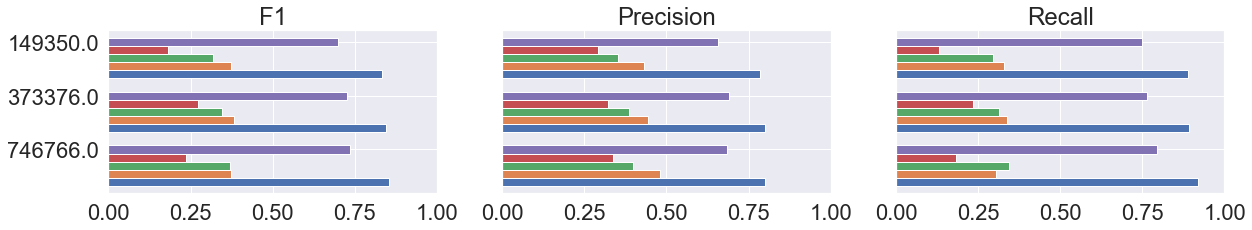

In [8]:
import util.plot_util as pu
print("LSTM (16 Units)")
pu.plot_score_histograms(report_lstm16, version=2, label="train_examples")

LSTM (32 Units)


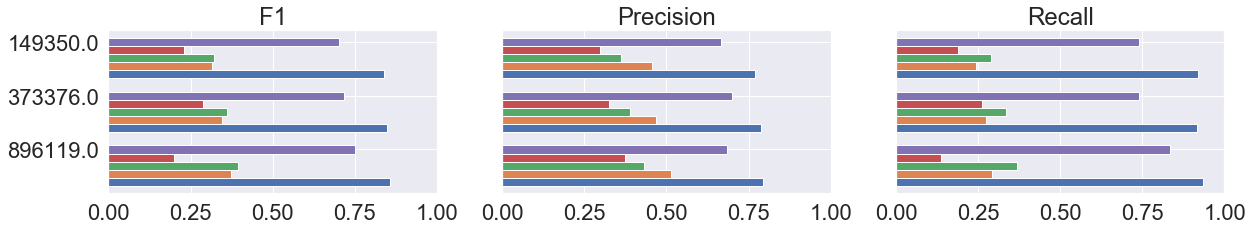

In [9]:
print("LSTM (32 Units)")
pu.plot_score_histograms(report_lstm32, version=2, label="train_examples")

LSTM (64 Units No Dropout)


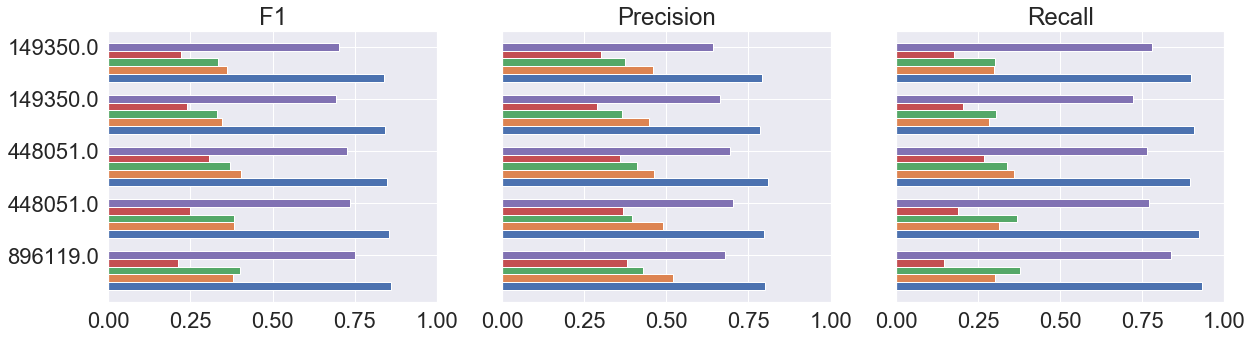

In [10]:
print("LSTM (64 Units No Dropout)")
pu.plot_score_histograms(report_lstm64_nodrop, version=2, label="train_examples")

LSTM (64 Units 20% Dropout)


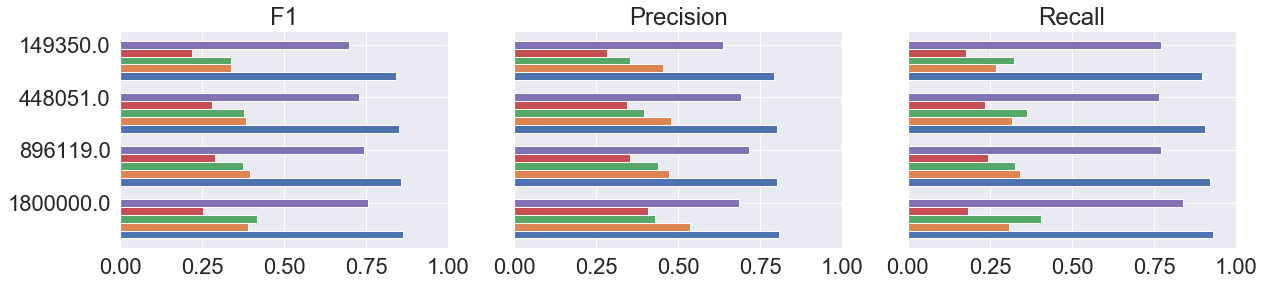

In [11]:
print("LSTM (64 Units 20% Dropout)")
pu.plot_score_histograms(report_lstm64, version=2, label="train_examples")